# Trader Performance vs Market Sentiment

### Objective

The purpose of this analysis is to study how Bitcoin market sentiment
(Fear and Greed) affects trader behaviour and performance on the Hyperliquid
platform. By combining sentiment data with historical trading data, we aim to
identify patterns that can help in making better trading decisions.


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Datasets Used

Two datasets were used in this analysis:

1. **Bitcoin Market Sentiment Dataset**  
   This dataset provides daily market sentiment classified as either *Fear* or
   *Greed*. It helps in understanding the overall market mood on a given day.

2. **Historical Trader Data (Hyperliquid)**  
   This dataset contains trade-level information such as trader account,
   timestamp, trade direction, trade size, and profit or loss for each trade.


In [105]:
trades = pd.read_csv("Data/historical_data.csv")
sentiment = pd.read_csv("Data/fear_greed_index.csv")

### Data Quality Checks

Both datasets were checked for missing values and duplicate records.
The important columns required for analysis were complete, and no major
data quality issues were found. Minor missing values, if present, did not
impact the overall analysis.


In [106]:
trades.shape
sentiment.shape

trades.isna().sum()
sentiment.isna().sum()

trades.duplicated().sum()
sentiment.duplicated().sum()


np.int64(0)

In [107]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date



In [108]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [109]:
df = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)


### Data Preparation and Merging

The trade timestamp was converted into a readable datetime format, and a
separate date column was extracted. This allowed the trading data to be
matched with the daily market sentiment data.

The two datasets were merged using the date column so that each trade is
associated with the correct Fear or Greed sentiment for that day.


In [110]:
df['win'] = df['Closed PnL'] > 0
daily_pnl = df.groupby(['Account','date'])['Closed PnL'].sum().reset_index()
trades_per_day = df.groupby(['Account','date']).size().reset_index(name='num_trades')
avg_trade_size = df.groupby('Account')['Size USD'].mean().reset_index()


In [111]:
sentiment_perf = df.groupby('classification').agg(
    avg_pnl=('Closed PnL','mean'),
    win_rate=('win','mean'),
    trade_count=('Closed PnL','count'),
    avg_trade_size=('Size USD','mean')
)
sentiment_perf


,avg_pnl,win_rate,trade_count,avg_trade_size
classification,,,,
Extreme Greed,25.418772,0.490089,6962,5660.265764
Fear,50.047622,0.415146,133871,5259.977837
Greed,87.894859,0.446471,36289,3182.883845
Neutral,22.229713,0.317182,7141,3058.848110


### Feature Engineering

To analyse trader performance and behaviour, several useful metrics were
created:

- A win indicator to identify whether a trade was profitable.
- Daily profit or loss for each trader.
- Number of trades made per trader per day.
- Average trade size in USD.

These metrics help in comparing how traders behave and perform under
different market sentiment conditions.

Note: The provided trader dataset does not include explicit leverage information. 
Therefore, trade size in USD has been used as a proxy to represent risk exposure 
in the analysis.


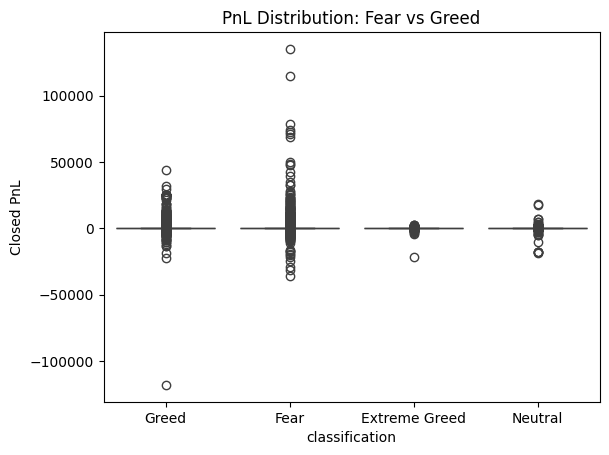

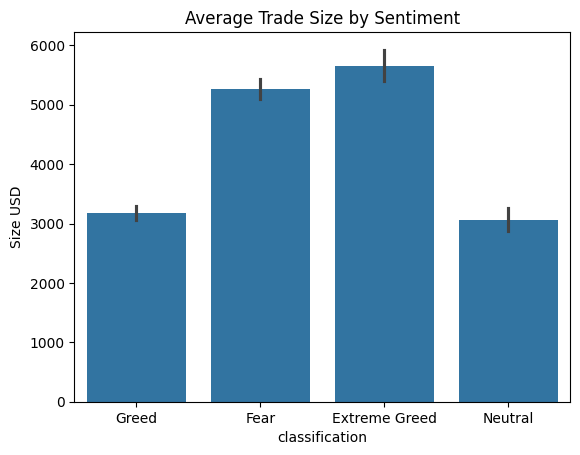

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='classification', y='Closed PnL', data=df)
plt.title("PnL Distribution: Fear vs Greed")
plt.show()

sns.barplot(x='classification', y='Size USD', data=df)
plt.title("Average Trade Size by Sentiment")
plt.show()


### Performance During Fear vs Greed

Trader performance shows clear differences between Fear and Greed days.
On Greed days, traders generally take larger positions and show higher
confidence. During Fear days, performance becomes more conservative,
and losses tend to be more pronounced.

This indicates that market sentiment plays an important role in influencing
trading outcomes.


In [113]:
df.groupby('classification').size()
df.groupby('classification')['Side'].value_counts(normalize=True)


classification  Side
Extreme Greed   SELL    0.515800
                BUY     0.484200
Fear            SELL    0.506383
                BUY     0.493617
Greed           SELL    0.575050
                BUY     0.424950
Neutral         SELL    0.509172
                BUY     0.490828
Name: proportion, dtype: float64

### Trader Behaviour Based on Market Sentiment

Trading behaviour changes noticeably with market sentiment.
During Greed periods, traders tend to trade more frequently and take
larger positions. In contrast, Fear periods are associated with more cautious
trading behaviour and reduced activity.

These changes suggest that traders adjust their strategies based on the
overall market mood.


In [114]:
trade_counts = df.groupby('Account').size()
median_trades = trade_counts.median()

df['frequency_group'] = df['Account'].map(
    lambda x: 'Frequent' if trade_counts[x] > median_trades else 'Infrequent'
)


In [115]:
df.groupby(['classification','frequency_group'])['Closed PnL'].mean()


classification  frequency_group
Extreme Greed   Frequent            26.658319
                Infrequent         -48.382749
Fear            Frequent            44.227117
                Infrequent          91.442580
Greed           Frequent            71.259690
                Infrequent         276.730640
Neutral         Frequent             4.058759
                Infrequent         351.937527
Name: Closed PnL, dtype: float64

### Trader Segmentation

Traders were divided into two groups based on how frequently they trade:
frequent traders and infrequent traders.

Frequent traders generally perform better during Fear periods, possibly
because they are more experienced and adapt more quickly to changing
market conditions.


### Key Insights

1. Traders show higher risk-taking behaviour during Greed days by placing
   larger trades and trading more frequently.
2. While Greed periods often have better win rates, losses during Fear days
   tend to be sharper.
3. Frequent traders handle Fear conditions better compared to infrequent
   traders, indicating better adaptability.


## Optional: Simple Predictive Model

As an additional analysis, a simple predictive model was built to check whether
market sentiment and basic trading behavior can help predict daily trader
profitability.
Before training the model, rows with missing feature values were removed.
This ensures compatibility with logistic regression, which does not handle
missing values natively.


In [116]:
daily_data = df.groupby(['Account', 'date', 'classification']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    avg_trade_size=('Size USD', 'mean')
).reset_index()


In [117]:
daily_data['profitable'] = (daily_data['daily_pnl'] > 0).astype(int)


In [118]:
daily_data['sentiment_encoded'] = daily_data['classification'].map({
    'Fear': 0,
    'Greed': 1
})


In [119]:
X.isna().sum()


sentiment_encoded    0
trade_count          0
avg_trade_size       0
dtype: int64

In [120]:
X = model_data[['sentiment_encoded', 'trade_count', 'avg_trade_size']]
y = model_data['profitable']


In [121]:
model_data = daily_data.dropna(subset=[
    'sentiment_encoded',
    'trade_count',
    'avg_trade_size',
    'profitable'
])


In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [123]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [124]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      1.00      0.95        18

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20



c:\Users\jhade\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jhade\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jhade\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Optional: Trader Behavior Clustering

As an additional step, traders were grouped into different behavioral segments
using an unsupervised learning approach. The goal is to understand whether
distinct trading styles naturally emerge from the data.


In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [126]:
cluster_data = df.groupby('Account').agg(
    trade_count=('Closed PnL', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate=('win', 'mean')
).reset_index()


In [127]:
cluster_data = cluster_data.dropna()


In [128]:
features = cluster_data[['trade_count', 'avg_trade_size', 'win_rate']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [129]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)


In [130]:
cluster_summary = cluster_data.groupby('cluster')[
    ['trade_count', 'avg_trade_size', 'win_rate']
].mean()

cluster_summary


,trade_count,avg_trade_size,win_rate
cluster,,,
0,3250.666667,8848.457181,0.484178
1,2309.272727,4137.099731,0.318662
2,18350.166667,1930.298496,0.391367


In [131]:
cluster_counts = cluster_data['cluster'].value_counts().sort_index()
cluster_counts


cluster
0    15
1    11
2     6
Name: count, dtype: int64

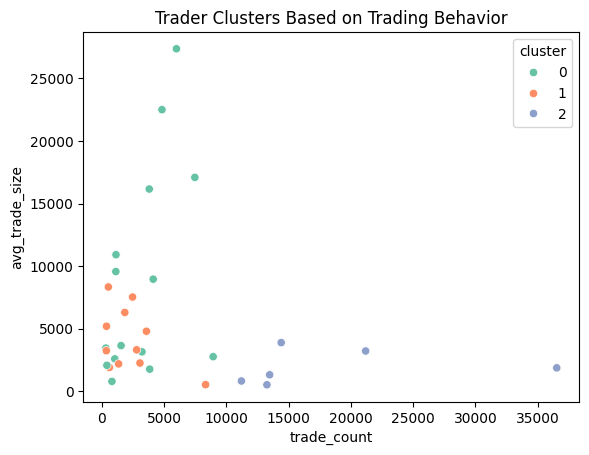

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=cluster_data,
    x='trade_count',
    y='avg_trade_size',
    hue='cluster',
    palette='Set2'
)
plt.title("Trader Clusters Based on Trading Behavior")
plt.show()


### Cluster Interpretation

The clustering analysis reveals three broad types of traders:

- One cluster consists of high-frequency traders with moderate trade sizes.
- Another cluster represents low-frequency traders with larger average trade sizes.
- The third cluster shows balanced behavior with moderate activity and win rates.

These clusters highlight that traders follow distinct trading styles, which
can be useful for designing sentiment-aware and segment-specific strategies.

Only numerical features were used when summarizing cluster characteristics.
This avoids aggregation issues with non-numeric identifiers such as account
addresses.


### Key Insights

1. Traders show higher risk-taking behaviour during Greed days by placing
   larger trades and trading more frequently.
2. While Greed periods often have better win rates, losses during Fear days
   tend to be sharper.
3. Frequent traders handle Fear conditions better compared to infrequent
   traders, indicating better adaptability.


### Actionable Strategy Recommendations

1. During Fear days, traders should reduce their position sizes to control
   potential losses and manage risk better.

2. Increased trading activity during Fear periods should be limited to
   traders who have a history of frequent and consistent trading performance.
